In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import sys
import pysam
from Bio.Seq import Seq
import pyranges as pr
import re
from rapidfuzz import fuzz
import mappy as mp
import shutil
import os

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess

sys.path.append("../")
import utils as ut

# Build the barcode file

In [2]:
# write the barcode file
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/results/HSC/demultiplex/Gridr1.putative_bc.csv"
df = pd.read_csv(fpath)
print(f"{df.shape=}")
df.head()

df.shape=(14626355, 7)


,read_id,putative_bc,putative_bc_min_q,putative_umi,umi_end,pre_bc_flanking,post_umi_flanking
0,7ca01f6b-1455-4f05-ba7a-4b983ad8f534,NaN,NaN,NaN,NaN,NaN,NaN
1,ffa5cb0c-acb8-49b3-b0cb-9c757ec92615,GATAGAAGTACCAGAG,4.0,GCTAATGAGTAG,-104.0,GATCT,TTTTT
2,d49d4023-4d20-4e40-afdf-c691ac7e47e8,NaN,NaN,NaN,NaN,NaN,NaN
3,0f84e905-dfbf-4343-ac98-5a9a4d1c22ea,CCGCGAGTCATGAGTC,6.0,GGGACAGGTTAA,150.0,GATCT,TTTTT
4,13d4e220-ff2c-4c0e-aa40-afb93c5fa937,CGATGCGTCATGAGTC,17.0,CATGCTATGCGT,-98.0,GATCT,TTTTT


In [3]:
summary = pd.DataFrame(np.sign(df['umi_end']))
summary.value_counts(dropna=False, normalize=True)

umi_end
 1.0       0.472278
-1.0       0.413786
NaN        0.113935
Name: proportion, dtype: float64

# Filter the easy targets first

In [4]:
pdf = df.copy()
pdf = pdf[pdf['putative_bc'].notna()]

# only forward stand barcodes are detectable
pdf = pdf[pdf['umi_end'] > 0]

# now we create a barcode list with each read
# assigned to that barcode 
bc_lookup = pdf.groupby('putative_bc')['read_id'].apply(list).to_dict()
print(len(bc_lookup.keys()))

1747672


# build barcode fasta

In [5]:
ONT_primer = "ATCGCCTACCGTGACAAGAAAGTTGTCGGTGTCTTTGTGACTTGCCTGTCGCTCTATCTTC"
RAPT = "TTTTTTTTCCTGTACTTCGTTCAGTTACGTATTGCT"
P5 = "AATGATACGGCGACCACCGAGATCTACAC"
i5 = "TGCCTGTCGC"
# i5 = "N" * 12
truseq = "ACACTCTTTCCCTACACGACGCTCTTCCGATCT"
umi = "N" * 12

outpath = "./barcodes.fasta"

# remove if exists
if os.path.exists(outpath):
  os.remove(outpath)

with open(outpath, 'w') as outfile:
    for barcode, reads in bc_lookup.items():
        n_reads = len(reads)
        read_str = ";".join(reads)
    
        bc_seq = f"{truseq}{barcode}"
        new_read_name = f"{barcode}:{n_reads}"
    
        print(f">{new_read_name}", file=outfile)
        print(f"{bc_seq}", file=outfile)

print('done')

done


# Align sequences

In [6]:
def run_minimap2(sequence_file, barcode_file, output_file,
                 k=15, w=10, n=1, m=20):
    minimap2 = "/home/cstansbu/miniconda3/envs/scpc/bin/minimap2"
    samtools = "/home/cstansbu/miniconda3/envs/scpc/bin/samtools"

    # Build the command list
    command = [
        minimap2,
        f'-ax sr -k {k} -w {w} -n {n} -m {m} -t 8',
        barcode_file,
        sequence_file,
        '|',
        samtools,
        'sort',
        '-O bam',
        '-o',
        output_file
    ]
    # Execute the command using subprocess.run
    output = subprocess.run(" ".join(command), shell=True, capture_output=True)
    print(f"Wrote: {output_file}")
    return output

sequence_file = 'sample.fastq.gz'
barcode_file = 'barcodes.fasta'
output_file = "alignments.bam"

out = run_minimap2(sequence_file, 
             barcode_file,
             output_file,
             k=15, 
             w=10, 
             n=1, 
             m=10)

print(out)

Wrote: alignments.bam
CompletedProcess(args='/home/cstansbu/miniconda3/envs/scpc/bin/minimap2 -ax sr -k 15 -w 10 -n 1 -m 10 -t 8 barcodes.fasta sample.fastq.gz | /home/cstansbu/miniconda3/envs/scpc/bin/samtools sort -O bam -o alignments.bam', returncode=0, stdout=b'', stderr=b'[M::mm_idx_gen::1.396*1.33] collected minimizers\n[M::mm_idx_gen::1.554*1.67] sorted minimizers\n[M::main::2.530*1.07] loaded/built the index for 1747672 target sequence(s)\n[M::mm_mapopt_update::2.530*1.07] mid_occ = 1000\n[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1747672\n[M::mm_idx_stat::2.549*1.07] distinct minimizers: 1095461 (78.25% are singletons); average occurrences: 8.448; average spacing: 9.254; total length: 85635928\n[M::worker_pipeline::4.160*1.21] mapped 5000 sequences\n[M::main] Version: 2.24-r1122\n[M::main] CMD: /home/cstansbu/miniconda3/envs/scpc/bin/minimap2 -ax sr -k 15 -w 10 -n 1 -m 10 -t 8 barcodes.fasta sample.fastq.gz\n[M::main] Real time: 4.180 sec; CPU: 5.061 sec; Peak 

# Look at the output

In [7]:
def parse_bamfile(bampath, bc_lookup):
    """ A function to parse a bam file """
    bamfile = pysam.AlignmentFile(bampath)
    
    res = []
    for align in bamfile:
        ref_name = align.reference_name
        if ref_name is None:
            continue
            
        barcode = ref_name.split(":")[0]
        n_reads = ref_name.split(":")[1]

        hit = False
        if align.qname in bc_lookup[barcode]:
            hit = True
        
        align_record = {
            'read_name' : align.qname,
            'barcode' : barcode,
            'n_reads' : n_reads,
            'hit' : hit,
            'read_start' : align.qstart,
            'read_end' : align.qend,
            'mapping_quality' : align.mapping_quality,
            'sequence' : align.seq,
        }
        res.append(align_record)
    
    res = pd.DataFrame(res)
    return res

res = parse_bamfile(output_file, bc_lookup)
print(res['hit'].value_counts())
print(f"{res['read_name'].nunique()=}")
res.head()

[E::idx_find_and_load] Could not retrieve index file for 'alignments.bam'


hit
False    3515
True     1467
Name: count, dtype: int64
res['read_name'].nunique()=4358


,read_name,barcode,n_reads,hit,read_start,read_end,mapping_quality,sequence
0,fd44aded-4d89-4ff8-b94c-6c522f9d50aa,AAAAAAAAAAAAAAAA,3,False,0,22,1,CGATCTAAAAAAAAAAAAAAAA
1,9e6e545c-3338-4680-92a8-9b247d4b3cac,AAAAAAAAAAAAAAAA,3,False,0,21,3,GATCTAAAAAAAAAAAAAAAA
2,23a85dd8-9be1-4581-ba99-cb6bc95ff40c,AAAAAAAAAAAAAAAA,3,False,614,635,1,ACTTGTACTTCGTTCAGTTGTGTTTGGGTGTTGCTTGGTCGCTAAC...
3,ecd5e870-e8a6-48a8-96c2-2c4fa3a3a9c4,AAAAAAAAAAAAAAAA,3,False,0,21,1,GATCTAAAAAAAAAAAAAAAA
4,b66333dc-c1a4-48e4-9303-962f02ebcc20,AAAAAAAAAAAAAAAA,3,False,490,511,1,TGTGACAAGAAAGTTGTCGGTGTCTTTGTGTTTCTGTTGGTGCTGA...


# Determine best alignment params

In [8]:
def delete_and_create_folder(folder_path):
    """Safely delete a folder if it exists and then create it."""
    # Delete the folder if it exists
    if os.path.exists(folder_path):
        try:
            shutil.rmtree(folder_path)
        except OSError:
            pass

    # Create the folder
    os.makedirs(folder_path)

In [9]:
output_dir = "alignments/"
delete_and_create_folder(output_dir)

sequence_file = 'sample.fastq.gz'
barcode_file = 'barcodes.fasta'

n = 1

for k in [10, 13, 15]:
    for w in [2, 3, 5, 7]:
        for m in [1, 2, 5]:
            output_file = f"{output_dir}align_{k}_{w}_{n}_{m}.bam"
            run_minimap2(sequence_file, 
                         barcode_file,
                         output_file,
                         k=k, 
                         w=w, 
                         n=n, 
                         m=m,)

print('done')

Wrote: alignments/align_10_2_1_1.bam
Wrote: alignments/align_10_2_1_2.bam
Wrote: alignments/align_10_2_1_5.bam
Wrote: alignments/align_10_3_1_1.bam
Wrote: alignments/align_10_3_1_2.bam
Wrote: alignments/align_10_3_1_5.bam
Wrote: alignments/align_10_5_1_1.bam
Wrote: alignments/align_10_5_1_2.bam
Wrote: alignments/align_10_5_1_5.bam
Wrote: alignments/align_10_7_1_1.bam
Wrote: alignments/align_10_7_1_2.bam
Wrote: alignments/align_10_7_1_5.bam
Wrote: alignments/align_13_2_1_1.bam
Wrote: alignments/align_13_2_1_2.bam
Wrote: alignments/align_13_2_1_5.bam
Wrote: alignments/align_13_3_1_1.bam
Wrote: alignments/align_13_3_1_2.bam
Wrote: alignments/align_13_3_1_5.bam
Wrote: alignments/align_13_5_1_1.bam
Wrote: alignments/align_13_5_1_2.bam
Wrote: alignments/align_13_5_1_5.bam
Wrote: alignments/align_13_7_1_1.bam
Wrote: alignments/align_13_7_1_2.bam
Wrote: alignments/align_13_7_1_5.bam
Wrote: alignments/align_15_2_1_1.bam
Wrote: alignments/align_15_2_1_2.bam
Wrote: alignments/align_15_2_1_5.bam
W

In [10]:
res = []

for file_name in os.listdir(output_dir):
    if file_name.endswith(".bam"):
        bam_path = os.path.join(output_dir, file_name)
        tmp = parse_bamfile(bam_path, bc_lookup)
        tmp['k'] = file_name.split("_")[1]
        tmp['w'] = file_name.split("_")[2]
        tmp['n'] = file_name.split("_")[3]
        tmp['m'] = file_name.split("_")[4].replace(".bam", "")
        res.append(tmp)

res = pd.concat(res)
res.head()

[E::idx_find_and_load] Could not retrieve index file for 'alignments/align_13_5_1_5.bam'
[E::idx_find_and_load] Could not retrieve index file for 'alignments/align_13_2_1_1.bam'
[E::idx_find_and_load] Could not retrieve index file for 'alignments/align_10_3_1_5.bam'
[E::idx_find_and_load] Could not retrieve index file for 'alignments/align_15_3_1_2.bam'
[E::idx_find_and_load] Could not retrieve index file for 'alignments/align_10_2_1_1.bam'
[E::idx_find_and_load] Could not retrieve index file for 'alignments/align_10_5_1_5.bam'
[E::idx_find_and_load] Could not retrieve index file for 'alignments/align_13_5_1_1.bam'
[E::idx_find_and_load] Could not retrieve index file for 'alignments/align_15_5_1_1.bam'
[E::idx_find_and_load] Could not retrieve index file for 'alignments/align_10_3_1_2.bam'
[E::idx_find_and_load] Could not retrieve index file for 'alignments/align_15_5_1_2.bam'
[E::idx_find_and_load] Could not retrieve index file for 'alignments/align_10_7_1_1.bam'
[E::idx_find_and_load

,read_name,barcode,n_reads,hit,read_start,read_end,mapping_quality,sequence,k,w,n,m
0,23a85dd8-9be1-4581-ba99-cb6bc95ff40c,AAAAAAAAAAAAAAAA,3,False,0,21,8,GATCTAAAAAAAAAAAAAAAA,13,5,1,5
1,b66333dc-c1a4-48e4-9303-962f02ebcc20,AAAAAAAAAAAAAAAA,3,False,490,511,1,TGTGACAAGAAAGTTGTCGGTGTCTTTGTGTTTCTGTTGGTGCTGA...,13,5,1,5
2,ba46a0ba-a1db-4c54-903f-b12cdb8678d1,AAAAAAAAAAAAAAAA,3,False,0,20,1,ATCTAAAAAAAAAAAAAAAA,13,5,1,5
3,fd44aded-4d89-4ff8-b94c-6c522f9d50aa,AAAAAAAAAAAAAAGG,1,False,0,20,1,CGATCTAAAAAAAAAAAAAA,13,5,1,5
4,eda01684-abf7-48a7-b00c-882530d90815,AAAAAAAAAAAAAGAA,1,False,0,20,7,ATCTAAAAAAAAAAAAAGAA,13,5,1,5


In [15]:
pdf = res.copy()

pdf  = pdf.groupby(['k', 'w', 'm']).agg(
    total = ('read_name', 'nunique'),
    hit = ('hit', 'sum'),
    mean_mapq = ('mapping_quality', 'mean'),
    min_mapq = ('mapping_quality', 'min'),
    max_mapq = ('mapping_quality', 'max'),
).reset_index(drop=False)

pdf['hit_perc'] = pdf['hit'] / pdf['total']
pdf = pdf.sort_values(by='hit_perc', ascending=False)
pdf[['k', 'w', 'm']] =  pdf[['k', 'w', 'm']].astype(int)

pdf = pdf.sort_values(by='hit_perc', ascending=False)
pdf.head(20)

,k,w,m,total,hit,mean_mapq,min_mapq,max_mapq,hit_perc
25,15,2,2,4720,2411,2.456916,0,24,0.510805
26,15,2,5,4720,2411,2.236325,0,20,0.510805
24,15,2,1,4720,2411,2.523752,0,25,0.510805
14,13,2,5,4714,2404,2.009014,0,16,0.509970
13,13,2,2,4714,2404,2.140157,0,20,0.509970
12,13,2,1,4714,2404,2.183193,0,21,0.509970
17,13,3,5,4702,2393,2.113141,0,16,0.508932
16,13,3,2,4702,2393,2.262522,0,20,0.508932
15,13,3,1,4702,2393,2.314526,0,21,0.508932
28,15,3,2,4713,2389,2.595378,0,24,0.506896


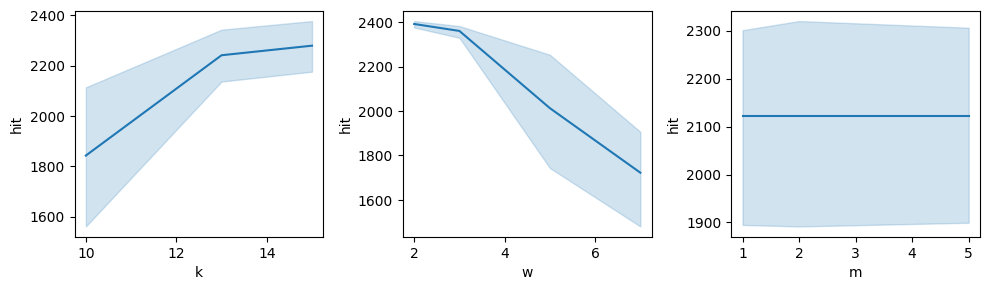

In [12]:
plt.rcParams['figure.figsize'] = 10, 3

fig, axs = plt.subplots(1, 3)

y = 'hit'

for i, col in enumerate(['k', 'w', 'm']):
    sns.lineplot(data=pdf,
                 x=col,
                 y=y,
                 ax=axs[i])

plt.tight_layout()

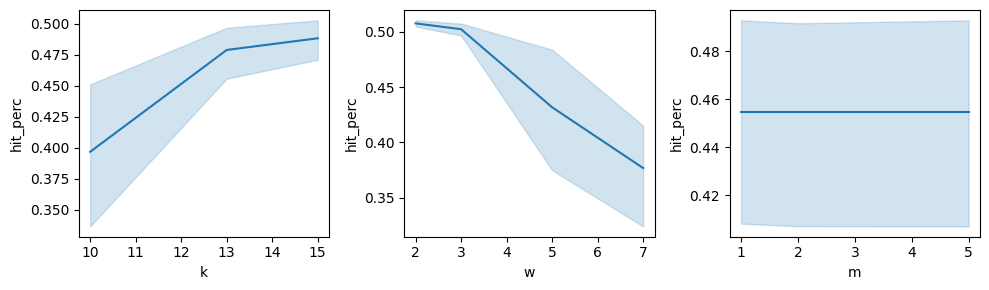

In [13]:
plt.rcParams['figure.figsize'] = 10, 3

fig, axs = plt.subplots(1, 3)

y = 'hit_perc'

for i, col in enumerate(['k', 'w', 'm']):
    sns.lineplot(data=pdf,
                 x=col,
                 y=y,
                 ax=axs[i])

plt.tight_layout()

# dig into actual reads

In [27]:
codes = df.copy()
codes = codes[codes['umi_end'] > 0]

bam_path = "alignments/align_15_2_1_2.bam" # choose a high performing set of alignments
pdf = parse_bamfile(bam_path, bc_lookup)

# merge the demultiplexed barcode info back on
pdf = pd.merge(pdf, codes, 
               how='left',
               left_on=['read_name', 'barcode'],
               right_on=['read_id', 'putative_bc']
)

print(f"total alignments: {pdf.shape[0]}")
print(f"total reads: {pdf['read_name'].nunique()}")
pdf = pdf[pdf['putative_bc'].notna()]

print(f"successfull alignments: {pdf.shape[0]}")
print(f"successfull reads: {pdf['read_name'].nunique()}")

pdf['barcode_end'] = pdf['umi_end'] - 12

pdf.head()

[E::idx_find_and_load] Could not retrieve index file for 'alignments/align_15_2_1_2.bam'


total alignments: 6673
total reads: 4720
successfull alignments: 2411
successfull reads: 2410


,read_name,barcode,n_reads,hit,read_start,read_end,mapping_quality,sequence,read_id,putative_bc,putative_bc_min_q,putative_umi,umi_end,pre_bc_flanking,post_umi_flanking,barcode_end
34,08bb7005-2710-45ca-827a-a6cd1f2b8efb,AAAAGTCGTGTTAAGA,1,True,101,139,3,TTGTACTTCGTTCAATTTAATTTTGGTGTTTAAACCGATTAAAACT...,08bb7005-2710-45ca-827a-a6cd1f2b8efb,AAAAGTCGTGTTAAGA,9.0,CATATGTTAGCG,151.0,GATCT,CGTTT,139.0
36,d4564751-c47d-4bbc-9f24-df4657c6911b,AAACCCATCAGGACGA,586,True,104,139,1,ATATGCTTTGTTCGGACACACGCCCTGAGTGGGTGTTTGTGATTAG...,d4564751-c47d-4bbc-9f24-df4657c6911b,AAACCCATCAGGACGA,20.0,CTATTTAACAAT,151.0,GATCT,TTTTT,139.0
38,d8253a69-a5c7-4df4-8dbb-d0be65b4de85,AAACGAACAGCGAACG,4,True,103,142,1,ACTTGTACTTCGTTCAGTTATCAGGTGGGTGTTTATGATTCAATAT...,d8253a69-a5c7-4df4-8dbb-d0be65b4de85,AAACGAACAGCGAACG,8.0,AGCTCGCCCAGA,154.0,GATCT,TTTTT,142.0
40,609f28de-2574-4483-b83c-e17e7cc512fc,AAACGCTAGTCTGGTT,572,True,106,145,1,CAGGCTCCTTCGCTACGTTCGGTGCAGTGGTGTTTCGGTCCATCGC...,609f28de-2574-4483-b83c-e17e7cc512fc,AAACGCTAGTCTGGTT,5.0,AGCTTCTCCATT,157.0,AGTCT,TTTTT,145.0
42,5519cfb5-7090-43fc-a99d-bdc7250662e6,AAACGCTCATGAGATA,393,True,90,124,1,CGCGCTTCGTTCGGTGCATTGATTGTTTATGATGTCATACCGTGAC...,5519cfb5-7090-43fc-a99d-bdc7250662e6,AAACGCTCATGAGATA,5.0,TGGCATCGTGTA,136.0,GATCT,TTTTT,124.0


Text(0, 0.5, 'Aligned Barcode Position')

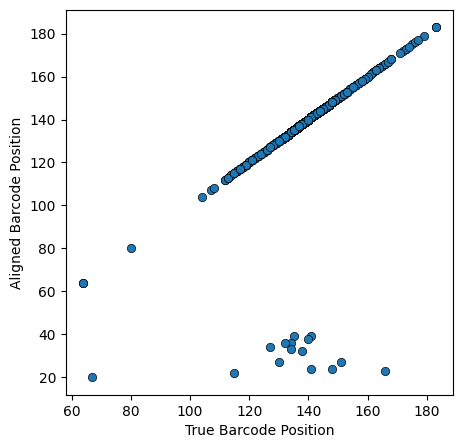

In [35]:
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(data=pdf, 
                x='barcode_end',
                y='read_end',
                ec='k',)

plt.xlabel('True Barcode Position')
plt.ylabel('Aligned Barcode Position')

In [46]:
# how many total reads in the fastq file?
fastq_path = "sample.fastq.gz"
fids = []
for read in pysam.FastqFile(fastq_path):
    fids.append(read.name)

print(f"Total reads {len(fids)}")

# count the reads that aligned
# load all alignments
bam_path = "alignments/align_15_2_1_2.bam" # choose a high performing set of alignments
pdf = parse_bamfile(bam_path, bc_lookup)
reads_aligned = [x for x in fids if x in pdf['read_name'].unique()]
print(f"Reads aligned {len(reads_aligned)}")

# count the reads that hit a true, known barcode
hits = pdf[pdf['hit']]
reads_hit = [x for x in fids if x in hits['read_name'].unique()]
print(f"Reads hit {len(reads_hit)}")


# count the reads that hit a known barcode 
# in the first 200 bp

hit2 = hits[hits['read_end'] < 200]
reads_hit2 = [x for x in fids if x in hit2['read_name'].unique()]
print(f"Reads hit {len(reads_hit2)}")

Total reads 5000


[E::idx_find_and_load] Could not retrieve index file for 'alignments/align_15_2_1_2.bam'


Reads aligned 4720
Reads hit 2410
Reads hit 2410


In [49]:
# count the actual distribution of demuliplexed barcodes
codes = df.copy()
codes = codes[codes['read_id'].isin(fids)]

summary = pd.DataFrame(np.sign(codes['umi_end']))
summary.value_counts(dropna=False, normalize=True)

umi_end
 1.0       0.4946
-1.0       0.3714
NaN        0.1340
Name: proportion, dtype: float64

In [50]:
2410 / 5000

0.482

In [52]:
len(truseq) + len(barcode)

49

In [14]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)